In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from prophet import Prophet
from neuralprophet import NeuralProphet
from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")
from matplotlib import pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.express as px
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import time
import numpy as np

In [2]:
m = NeuralProphet(n_changepoints=10,
                  n_lags=10,
                  changepoints_range=0.75,
                  learning_rate = 1.1)

df = pd.read_csv('../forecasting/historical_data/cable_retention_daily.csv', parse_dates=['ds'])
# df.loc[(df['ds'] > '2020-02-01') & (df['ds'] < '2020-12-01'), 'y'] = None
# create a test holdout set:
df_train_val, df_test = m.split_df(df=df, freq="D", valid_p=0.2)
# create a validation holdout set:
df_train, df_val = m.split_df(df=df_train_val, freq="D", valid_p=0.2)

In [3]:
# fit a model on training data and evaluate on validation set.
metrics_train1 = m.fit(df=df_train, freq="D")
metrics_val = m.test(df=df_val)


In [4]:
# refit model on training and validation data and evaluate on test set.
m = NeuralProphet(n_changepoints=10,
                  n_lags=10,
                  changepoints_range=0.75,
                  learning_rate = 1.1)
metrics_train2 = m.fit(df=df_train_val, freq="D")
metrics_test = m.test(df=df_test)

In [5]:
metrics_train1["split"]  = "train1"
metrics_train2["split"]  = "train2"
metrics_val["split"] = "validate"
metrics_test["split"] = "test"
metrics_train1.tail(1).append([metrics_train2.tail(1), metrics_val, metrics_test]).drop(columns=['RegLoss'])

,SmoothL1Loss,MAE,RMSE,split
180,0.003606,32.314693,43.222531,train1
168,0.003667,35.214443,47.399377,train2
0,0.010179,57.451736,74.053192,validate
0,0.006508,47.054321,64.117035,test


In [6]:
METRICS = ['SmoothL1Loss', 'MAE', 'RMSE']
params = {'n_changepoints': 10, 'n_lags': 10, 'changepoints_range': 0.75, 'learning_rate': 1.1}

df = pd.read_csv('../forecasting/historical_data/cable_retention_daily.csv', parse_dates=['ds'])
folds = NeuralProphet(**params).crossvalidation_split_df(df, freq="D", k=5, fold_pct=0.20, fold_overlap_pct=0.5)

In [7]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_test = pd.DataFrame(columns=METRICS)

for df_train, df_test in folds:
    m = NeuralProphet(**params)
    train = m.fit(df=df_train, freq="D")
    test = m.test(df=df_test)
    metrics_train = metrics_train.append(train[METRICS].iloc[-1])
    metrics_test = metrics_test.append(test[METRICS].iloc[-1])

In [8]:
metrics_test.describe()

,SmoothL1Loss,MAE,RMSE
count,5.000000,5.000000,5.000000
unique,5.000000,5.000000,5.000000
top,0.012901,42.423748,55.738987
freq,1.000000,1.000000,1.000000


In [9]:
metrics_val.describe()

,SmoothL1Loss,MAE,RMSE
count,1.000000,1.000000,1.000000
mean,0.010179,57.451736,74.053192
std,NaN,NaN,NaN
min,0.010179,57.451736,74.053192
25%,0.010179,57.451736,74.053192
50%,0.010179,57.451736,74.053192
75%,0.010179,57.451736,74.053192
max,0.010179,57.451736,74.053192


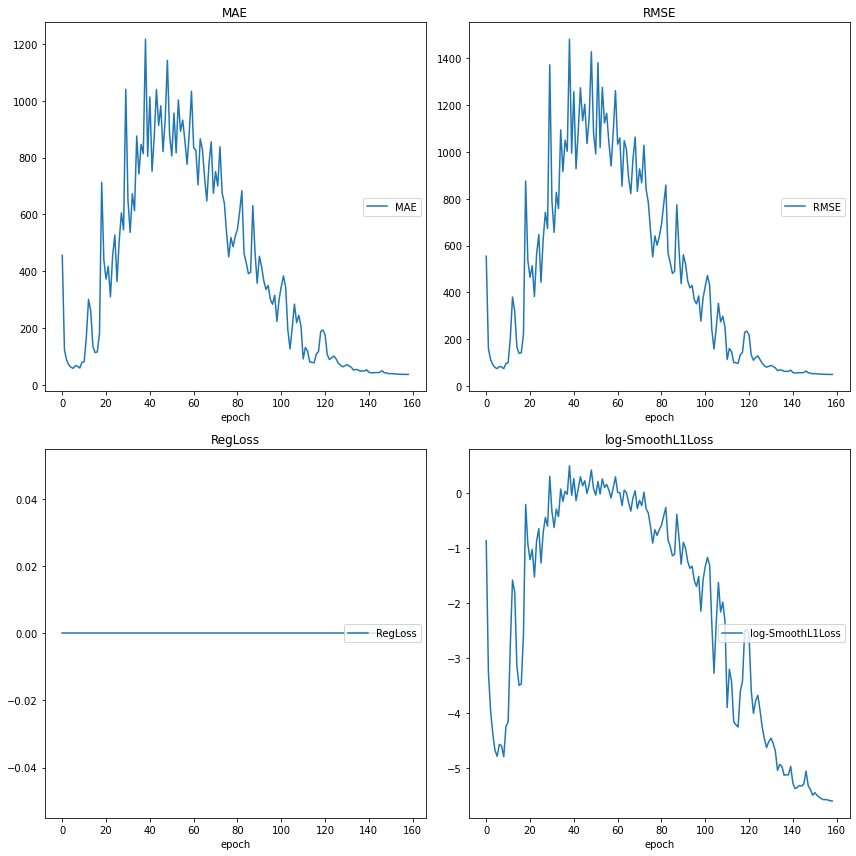

MAE
	MAE              	 (min:   36.784, max: 1217.139, cur:   36.784)
RMSE
	RMSE             	 (min:   49.736, max: 1482.631, cur:   49.741)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	log-SmoothL1Loss 	 (min:   -5.590, max:    0.489, cur:   -5.590)


In [10]:
m = NeuralProphet(n_changepoints=10,
                  n_lags=10,
                  changepoints_range=0.75,
                  learning_rate = 1.1
                 )
metrics = m.fit(df,progress='plot-all')

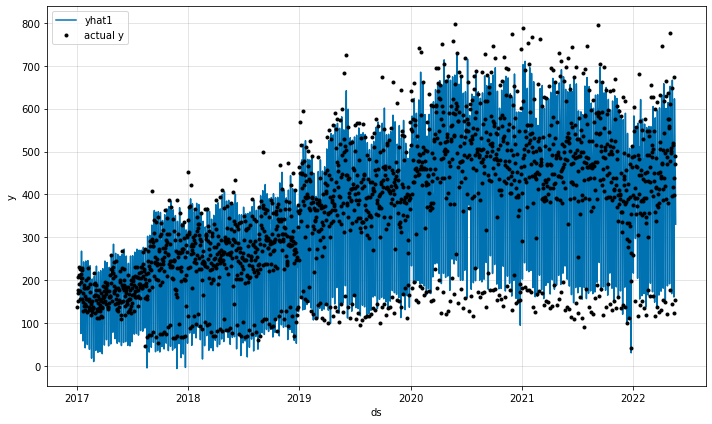

In [11]:
future = m.make_future_dataframe(df, periods=365, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)

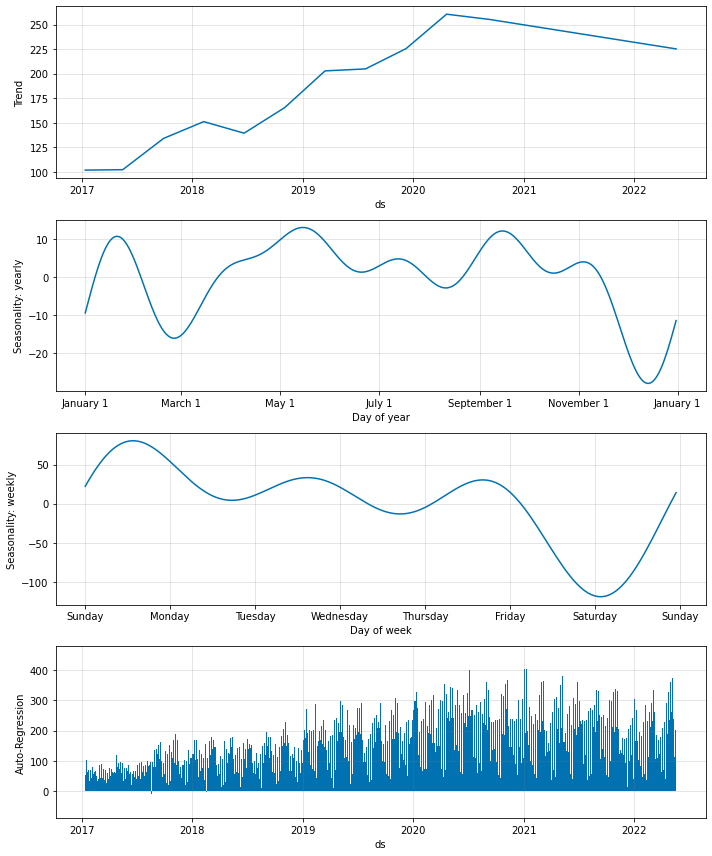

In [12]:
fig_comp = m.plot_components(forecast)


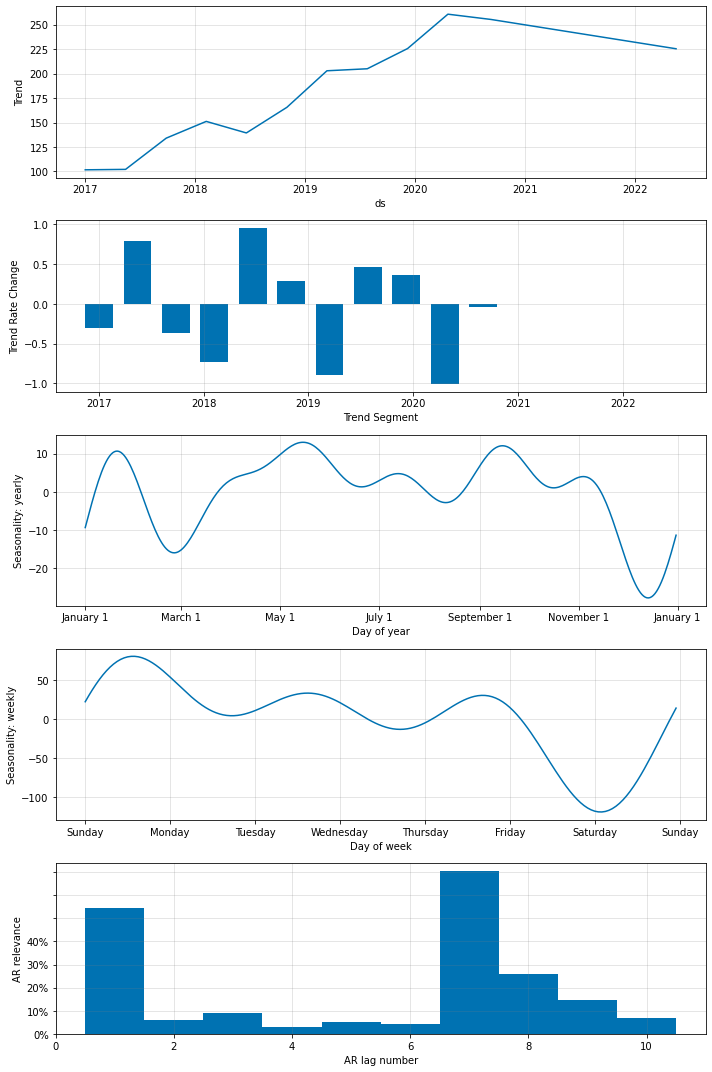

In [13]:
fig_param = m.plot_parameters()

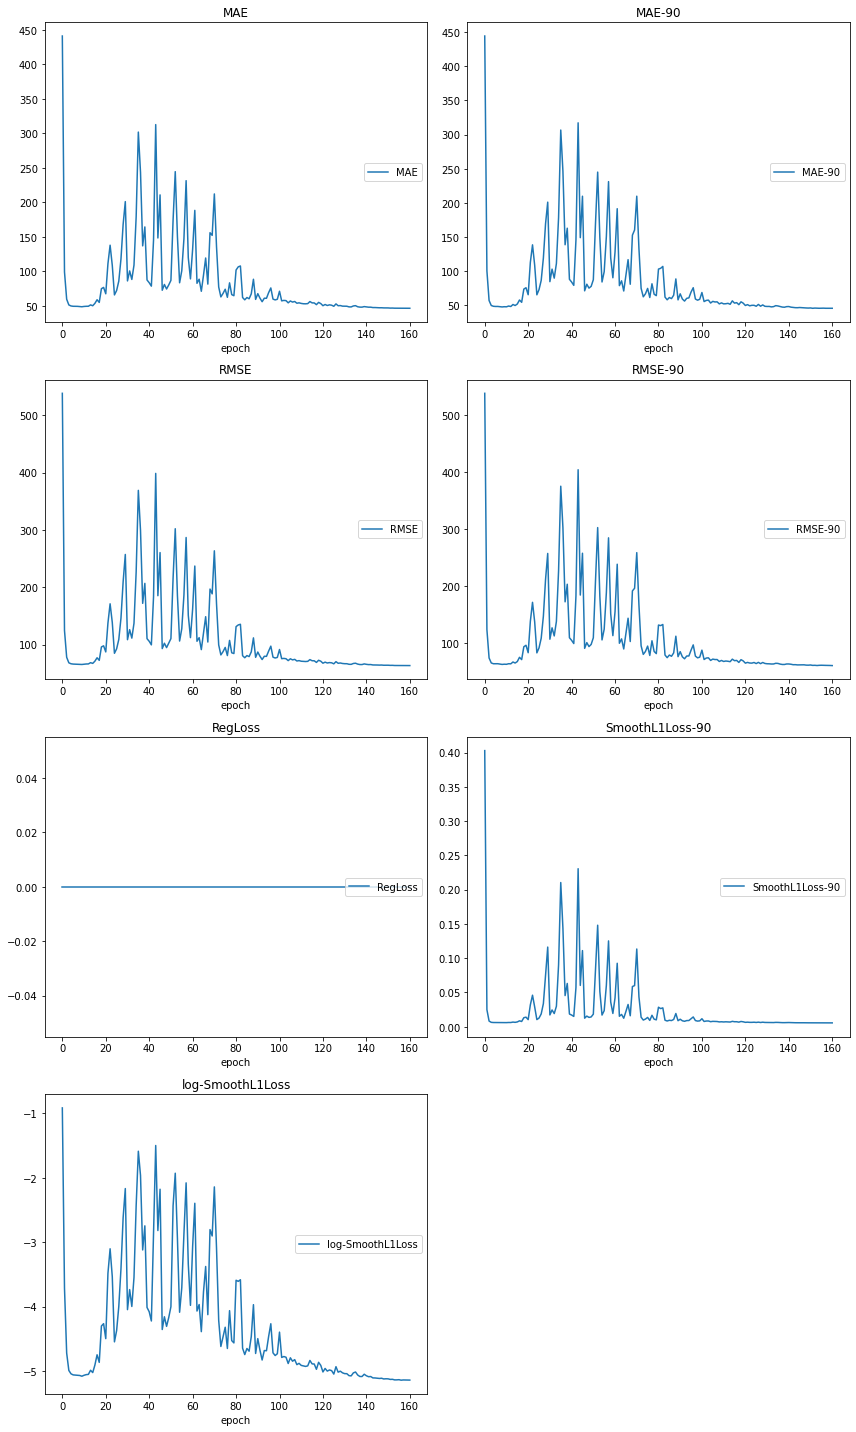

MAE
	MAE              	 (min:   46.336, max:  441.108, cur:   46.359)
MAE-90
	MAE-90           	 (min:   45.641, max:  444.432, cur:   45.653)
RMSE
	RMSE             	 (min:   63.217, max:  538.306, cur:   63.253)
RMSE-90
	RMSE-90          	 (min:   60.679, max:  537.580, cur:   60.679)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
SmoothL1Loss-90
	SmoothL1Loss-90  	 (min:    0.006, max:    0.403, cur:    0.006)
log-SmoothL1Loss
	log-SmoothL1Loss 	 (min:   -5.140, max:   -0.916, cur:   -5.139)


In [14]:
m = NeuralProphet(n_changepoints=10,
                  n_forecasts=90,
                  n_lags=30,
                  changepoints_range=0.75,
                  num_hidden_layers=1,
                  d_hidden=16,
                  learning_rate = 1.1
                 )
m = m.highlight_nth_step_ahead_of_each_forecast(90)
metrics = m.fit(df,progress='plot-all')

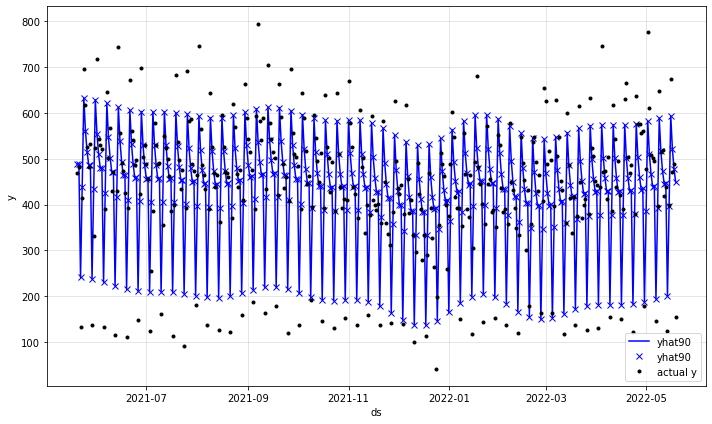

In [15]:
forecast = m.predict(df)
fig1 = m.plot(forecast[-365:])

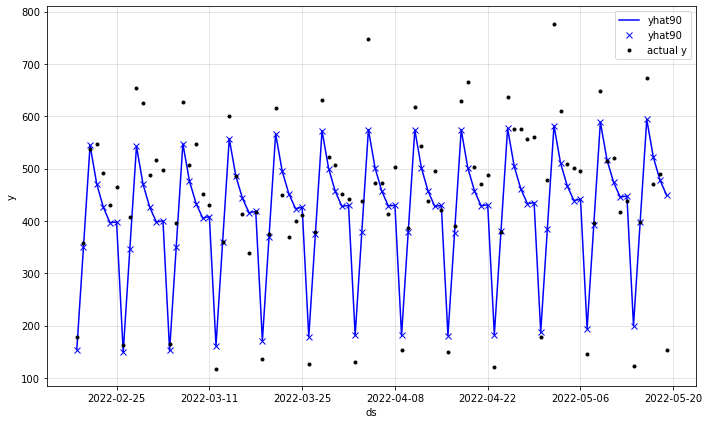

In [16]:
fig2 = m.plot(forecast[-90:])

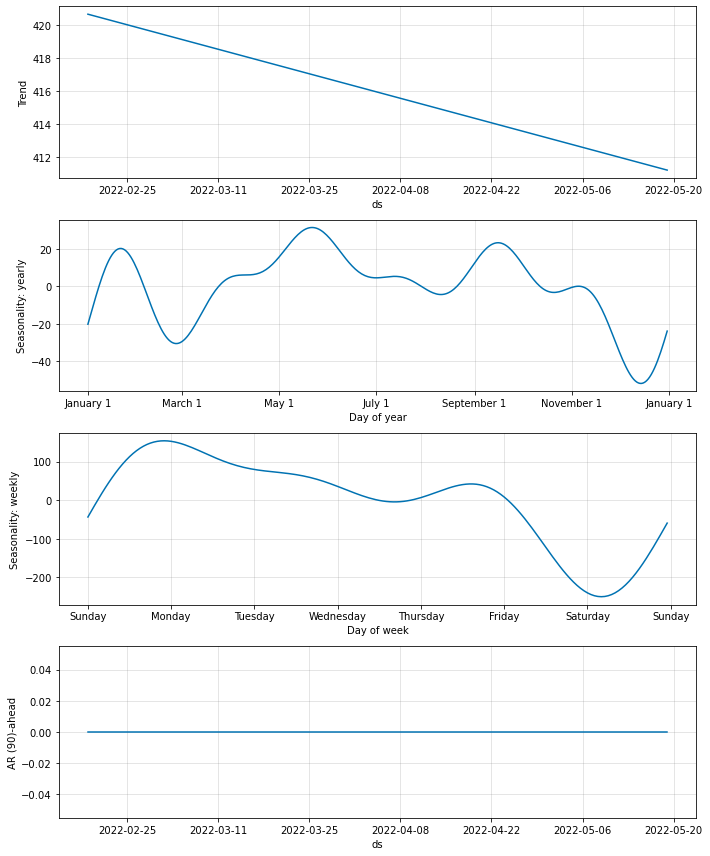

In [17]:
comp = m.plot_components(forecast[-90:])

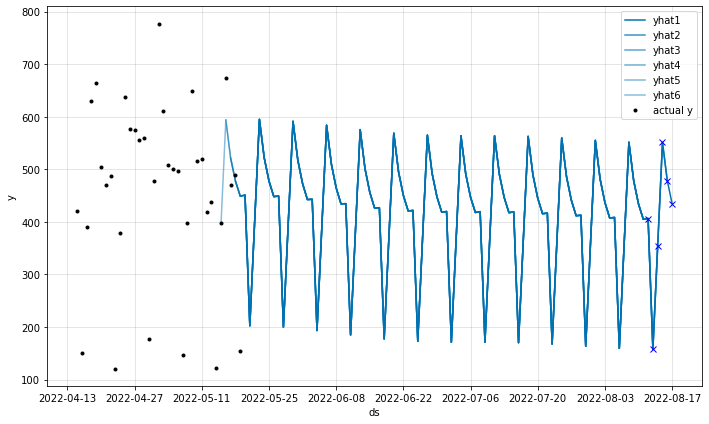

In [19]:
future = m.make_future_dataframe(df, periods=90*5)
forecast = m.predict(future)
fig = m.plot(forecast)